In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os

# dataset path
dataset_path = '/content/drive/MyDrive/fake-news-detection/Dataset/'

# Load the TSV files
train_df = pd.read_csv(os.path.join(dataset_path, 'multimodal_train.tsv'), sep='\t')
validate_df = pd.read_csv(os.path.join(dataset_path, 'multimodal_validate.tsv'), sep='\t')
test_df = pd.read_csv(os.path.join(dataset_path, 'multimodal_test_public.tsv'), sep='\t')

print("Training set shape:", train_df.shape)
print("\nValidation set shape:", validate_df.shape)
print("\nTest set shape:", test_df.shape)

Training set shape: (564000, 16)

Validation set shape: (59342, 16)

Test set shape: (59319, 16)


In [3]:
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

TARGET_TRAIN_SIZE = 10000
TARGET_VAL_SIZE = 2000

def check_url(row):
    """
    Returns the row if the URL is valid (Status 200), otherwise None.
    """
    url = row['image_url']
    try:

        response = requests.head(url, timeout=3, allow_redirects=True)
        if response.status_code == 200:
            return row
    except:
        return None
    return None

def get_clean_samples(df, target_size):
    """
    Iterates through the dataframe until it finds 'target_size' valid images.
    """
    clean_rows = []

    shuffled_df = df.sample(frac=1, random_state=42)

    print(f"Scanning for {target_size} valid images...")

    with ThreadPoolExecutor(max_workers=20) as executor:

        futures = []
        for i in range(len(shuffled_df)):
            futures.append(executor.submit(check_url, shuffled_df.iloc[i]))

            if len(futures) >= target_size * 2:
                break

        for future in tqdm(futures, total=len(futures)):
            result = future.result()
            if result is not None:
                clean_rows.append(result)
                if len(clean_rows) >= target_size:
                    break

    return pd.DataFrame(clean_rows)

print("Cleaning Training Set...")
df_train_clean = get_clean_samples(train_df, TARGET_TRAIN_SIZE)
print(f"Secured {len(df_train_clean)} valid training images.")

print("Cleaning Validation Set...")
df_val_clean = get_clean_samples(validate_df, TARGET_VAL_SIZE)
print(f"Secured {len(df_val_clean)} valid validation images.")

print("Cleaning Test Set...")
df_test_clean = get_clean_samples(test_df, TARGET_VAL_SIZE)
print(f"Secured {len(df_test_clean)} valid test images.")

Cleaning Training Set...
Scanning for 10000 valid images...


100%|██████████| 20000/20000 [01:04<00:00, 307.84it/s]


Secured 6763 valid training images.
Cleaning Validation Set...
Scanning for 2000 valid images...


100%|██████████| 4000/4000 [00:15<00:00, 255.41it/s]


Secured 1134 valid validation images.
Cleaning Test Set...
Scanning for 2000 valid images...


100%|██████████| 4000/4000 [00:13<00:00, 304.24it/s]

Secured 1087 valid test images.


In [4]:
import os
import requests
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

os.makedirs('train_images', exist_ok=True)
os.makedirs('val_images', exist_ok=True)
os.makedirs('test_images', exist_ok=True)

def download_image(args):
    url, filename, folder = args
    save_path = os.path.join(folder, filename)

    if os.path.exists(save_path):
        return

    try:
        response = requests.get(url, timeout=3)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
    except:
        pass

def run_download(df, folder_name):
    print(f"Downloading {len(df)} images to {folder_name}...")
    tasks = []

    for idx, row in df.iterrows():
        tasks.append((row['image_url'], f"{idx}.jpg", folder_name))

    with ThreadPoolExecutor(max_workers=20) as executor:
        list(tqdm(executor.map(download_image, tasks), total=len(tasks)))

print("Starting Image Downloads (This may take 2-3 minutes)...")
run_download(df_train_clean, 'train_images')
run_download(df_val_clean, 'val_images')
run_download(df_test_clean, 'test_images')
print("Download Complete!")

Starting Image Downloads (This may take 2-3 minutes)...


100%|██████████| 6763/6763 [00:32<00:00, 210.14it/s]


100%|██████████| 1134/1134 [00:07<00:00, 154.98it/s]


100%|██████████| 1087/1087 [00:04<00:00, 263.72it/s]

Download Complete!


In [6]:
import torch
import torch.nn as nn
from transformers import DistilBertModel
from torchvision import models
class ResNetBertClassifier(nn.Module):
    def __init__(self, num_labels=6):
        super(ResNetBertClassifier, self).__init__()

        # Text Encoder: DistilBERT
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Image Encoder: ResNet50
        resnet = models.resnet50(pretrained=True)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        self.classifier = nn.Linear(2048 + 768, num_labels)

        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.resnet.parameters():
            param.requires_grad = False

        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids, pixel_values, attention_mask):

        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.last_hidden_state[:, 0, :]

        image_features = self.resnet(pixel_values)
        image_features = image_features.view(image_features.size(0), -1)

        combined_features = torch.cat((image_features, text_features), dim=1)

        logits = self.classifier(combined_features)
        return logits

In [8]:
from torchvision import transforms, models
from transformers import DistilBertTokenizer, DistilBertModel
from PIL import Image
from torch.utils.data import Dataset

class HybridDataset(Dataset):
    def __init__(self, df, img_dir):
        self.data = df.reset_index(drop=True)
        self.indices = df.index.tolist()
        self.img_dir = img_dir

        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

        self.image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        text = str(self.data.iloc[idx]['clean_title'])
        label = self.data.iloc[idx]['6_way_label']

        original_idx = self.indices[idx]
        img_path = os.path.join(self.img_dir, f"{original_idx}.jpg")

        try:
            image = Image.open(img_path).convert("RGB")
        except:

            image = Image.new('RGB', (224, 224), color='black')

        pixel_values = self.image_transform(image)

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'pixel_values': pixel_values,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [10]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_ds = HybridDataset(df_train_clean, 'train_images')
val_ds   = HybridDataset(df_val_clean,   'val_images')
test_ds  = HybridDataset(df_test_clean,  'test_images')

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

model = ResNetBertClassifier(num_labels=6).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0

    for batch in tqdm(loader, desc="Training"):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids, pixel_values, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (logits.argmax(1) == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, pixel_values, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            correct += (logits.argmax(1) == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


epochs = 5
best_acc = 0

print("Starting Fast Training...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_resnetbert.pt')
        print("--> Model Saved!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 38.8MB/s]


Starting Fast Training...

Epoch 1/5


Training:   8%|▊         | 18/212 [00:05<00:40,  4.81it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  23%|██▎       | 49/212 [00:12<00:31,  5.21it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating:  14%|█▍        | 5/36 [00:01<00:07,  4.18it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating:  33%|███▎      | 12/36 [00:03<00:06,  3.96it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 36/36 [00:08<00:00,  4.33it/s]


Train Loss: 1.1268 | Acc: 0.5623
Val Loss:   1.0362 | Acc: 0.6067
--> Model Saved!

Epoch 2/5


Training:   2%|▏         | 5/212 [00:01<00:46,  4.45it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  16%|█▌        | 33/212 [00:06<00:38,  4.61it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating:  11%|█         | 4/36 [00:01<00:07,  4.14it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating:  28%|██▊       | 10/36 [00:02<00:05,  5.00it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 36/36 [00:07<00:00,  4.55it/s]


Train Loss: 0.9581 | Acc: 0.6314
Val Loss:   0.9201 | Acc: 0.6279
--> Model Saved!

Epoch 3/5


Training:   1%|▏         | 3/212 [00:00<01:01,  3.41it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  12%|█▏        | 25/212 [00:05<00:38,  4.82it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating:  17%|█▋        | 6/36 [00:02<00:08,  3.38it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating:  33%|███▎      | 12/36 [00:03<00:05,  4.14it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Train Loss: 0.8773 | Acc: 0.6694
Val Loss:   0.8546 | Acc: 0.6464
--> Model Saved!

Epoch 4/5


Training:   6%|▌         | 13/212 [00:03<00:40,  4.87it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  13%|█▎        | 28/212 [00:06<00:40,  4.58it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating:  11%|█         | 4/36 [00:01<00:07,  4.14it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating:  28%|██▊       | 10/36 [00:02<00:05,  4.67it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Train Loss: 0.8269 | Acc: 0.6913
Val Loss:   0.7985 | Acc: 0.6878
--> Model Saved!

Epoch 5/5


Training:   0%|          | 1/212 [00:00<01:56,  1.81it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  17%|█▋        | 35/212 [00:07<00:37,  4.76it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating:   8%|▊         | 3/36 [00:00<00:09,  3.66it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating:  28%|██▊       | 10/36 [00:02<00:05,  4.72it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 36/36 [00:08<00:00,  4.45it/s]


Train Loss: 0.7926 | Acc: 0.7041
Val Loss:   0.7657 | Acc: 0.7055
--> Model Saved!


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generating predictions...


  0%|          | 0/34 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 29%|██▉       | 10/34 [00:02<00:04,  4.81it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 34/34 [00:07<00:00,  4.67it/s]


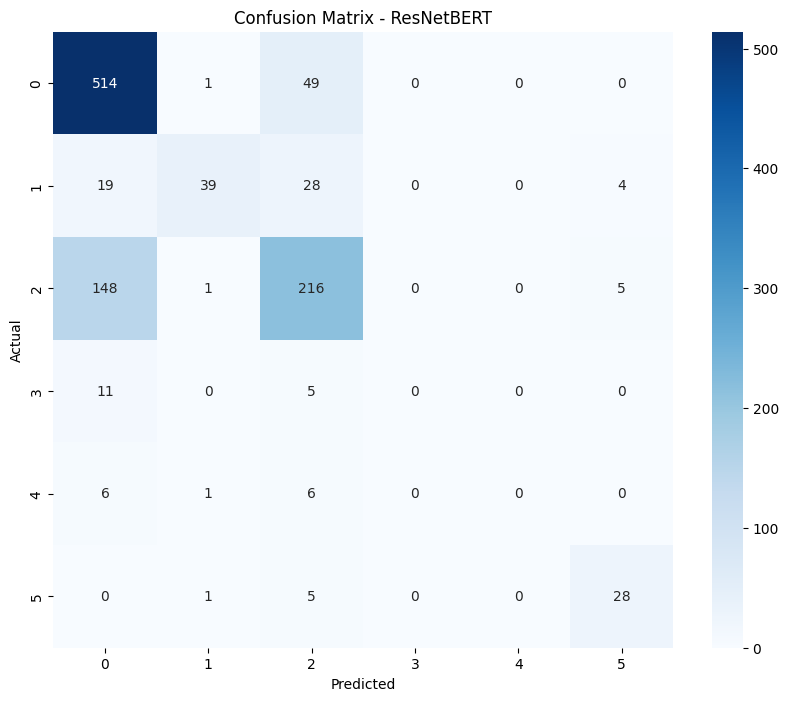

                  precision    recall  f1-score   support

            True     0.7364    0.9113    0.8146       564
          Satire     0.9070    0.4333    0.5865        90
False Connection     0.6990    0.5838    0.6362       370
        Imposter     0.0000    0.0000    0.0000        16
     Manipulated     0.0000    0.0000    0.0000        13
      Misleading     0.7568    0.8235    0.7887        34

        accuracy                         0.7332      1087
       macro avg     0.5165    0.4587    0.4710      1087
    weighted avg     0.7188    0.7332    0.7124      1087



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

best_model = ResNetBertClassifier(num_labels=6).to(device)
best_model.load_state_dict(torch.load('best_resnetbert.pt'))

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    print("Generating predictions...")
    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, pixel_values, attention_mask)
            _, preds = torch.max(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

preds, labels = get_predictions(best_model, test_loader)

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ResNetBERT')
plt.show()

# 5. Print Report
class_names = ['True', 'Satire', 'False Connection', 'Imposter', 'Manipulated', 'Misleading']
print(classification_report(labels, preds, target_names=class_names, digits=4))